In [1]:
import pdal
import json
import geopandas as gpd
from shapely.geometry import Polygon, Point
import sys
from logger import Logger
from file_read import FileHandler

In [2]:
class FetchData():
    def __init__(self, polygon: Polygon, region: str, epsg: str) -> None:
        try:
            self.logger = Logger().get_logger(__name__)
            self.json_path = "./get_data.json"
            self.file_handler = FileHandler()
            self.pipeline_json = self.file_handler.read_json(self.json_path)
            self.get_polygon_margin(polygon, epsg)
            self.public_data_url = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/"
            self.region = region
            self.epsg = epsg

            self.logger.info('Successfully Instantiated DataFetcher Class Object')

        except Exception as e:
            self.logger.exception('Failed to Instantiate DataFetcher Class Object')
            sys.exit(1)

    def get_polygon_margin(self, polygon: Polygon, epsg: str):
        try:
            gd_df = gpd.GeoDataFrame([polygon], columns=['geometry'])
            gd_df.set_crs(epsg=epsg, inplace=True)
            gd_df['geometry'] = gd_df['geometry'].to_crs(epsg=3857)
            minx, miny, maxx, maxy = gd_df['geometry'][0].bounds

            polygon_input = 'POLYGON(('
            xcords, ycords = gd_df['geometry'][0].exterior.coords.xy
            for x, y in zip(list(xcords), list(ycords)):
                polygon_input += f'{x} {y}, '
            polygon_input = polygon_input[:-2]
            polygon_input += '))'
            extraction_boundaries = f"({[minx, maxx]},{[miny,maxy]})"
            print(polygon_input)
            print(extraction_boundaries)
            self.logger.info( 'Successfully Extracted Polygon margin and Polygon Input')
            return extraction_boundaries, polygon_input
            
        except Exception as e:
            self.logger.exception(
                'Failed to Extract Polygon margin and Polygon Input')
    def get_pipeline(self, output_filename: str = "farm_land_IA_FullState"):

        try:
            with open(self.json_path) as json_file:
               self.pipeline_json = json.load(json_file) 
            extraction_boundaries, polygon_input = self.get_polygon_margin(polygon,self.epsg)
            full_dataset_path = f"{self.public_data_url}{self.region}/ept.json"
            self.pipeline_json['pipeline'][0]['filename'] = full_dataset_path
            self.pipeline_json['pipeline'][0]['bounds'] = extraction_boundaries
            self.pipeline_json['pipeline'][1]['polygon'] = polygon_input
            self.pipeline_json['pipeline'][3]['out_srs'] = f'EPSG:{self.epsg}'
            self.pipeline_json['pipeline'][4]['filename'] = "../data/laz/" + output_filename + ".laz"
            self.pipeline_json['pipeline'][5]['filename'] = "../data/tif/" + output_filename + ".tif"
            pipeline = pdal.Pipeline(json.dumps(self.pipeline_json))
            self.logger.info(f'extracting pipeline successfull.')
            print(pipeline)
            return pipeline  
                
        except RuntimeError as e:
            self.logger.exception('Pipeline extraction failed')
            print(e)
            
        
    def execute_pipeline(self):
        pipeline = self.get_pipeline()
        
        try: 
            pipeline.execute()
            self.logger.info(f'Pipeline executed successfully.')
            return pipeline
        except RuntimeError as e:
            self.logger.exception('Pipeline execution failed')
            print(e)

    def make_geo_df(self):
        try:
            elevations =[]
            geometry_points=[]
            for row in self.get_pipeline_arrays()[0]:
                lst = row.tolist()[-3:]
                elevations.append(lst[2])
                point = Point(lst[0], lst[1])
                geometry_points.append(point)
            geodf = gpd.GeoDataFrame(columns=["elevation", "geometry"])
            geodf['elevation'] = elevations
            geodf['geometry'] = geometry_points
            geodf = geodf.set_geometry("geometry")
            geodf.set_crs(epsg = self.epsg, inplace=True)
            self.logger.info(f'extracts geo dataframe')
            return geodf
        except RuntimeError as e:
            self.logger.exception('fails to extract geo data frame')
            print(e)
    def get_pipeline_arrays(self):
        return self.pipeline.arrays    
     
    def get_data(self):
        self.pipeline = self.execute_pipeline()
        return self.make_geo_df()

In [4]:
MINX, MINY, MAXX, MAXY = [-93.756155, 41.918015, -93.756055, 41.918115]
polygon = Polygon(((MINX, MINY), (MINX, MAXY), (MAXX, MAXY), (MAXX, MINY), (MINX, MINY)))
Fetch_data = FetchData(polygon=polygon, region="IA_FullState", epsg="4326") 
geo_df = Fetch_data.get_data()

POLYGON((-10436887.43333523 5148706.389047224, -10436887.43333523 5148721.349314567, -10436876.301386151 5148721.349314567, -10436876.301386151 5148706.389047224, -10436887.43333523 5148706.389047224))
([-10436887.43333523, -10436876.301386151],[5148706.389047224, 5148721.349314567])
POLYGON((-10436887.43333523 5148706.389047224, -10436887.43333523 5148721.349314567, -10436876.301386151 5148721.349314567, -10436876.301386151 5148706.389047224, -10436887.43333523 5148706.389047224))
([-10436887.43333523, -10436876.301386151],[5148706.389047224, 5148721.349314567])


In [5]:
geo_df

,elevation,geometry
0,310.03,POINT (-93.75606 41.91802)
1,310.15,POINT (-93.75611 41.91802)
2,310.14,POINT (-93.75613 41.91802)
3,310.10,POINT (-93.75614 41.91802)
4,309.90,POINT (-93.75615 41.91802)
...,...,...
174,310.21,POINT (-93.75613 41.91810)
175,310.22,POINT (-93.75609 41.91810)
176,310.07,POINT (-93.75609 41.91806)
177,310.05,POINT (-93.75608 41.91803)


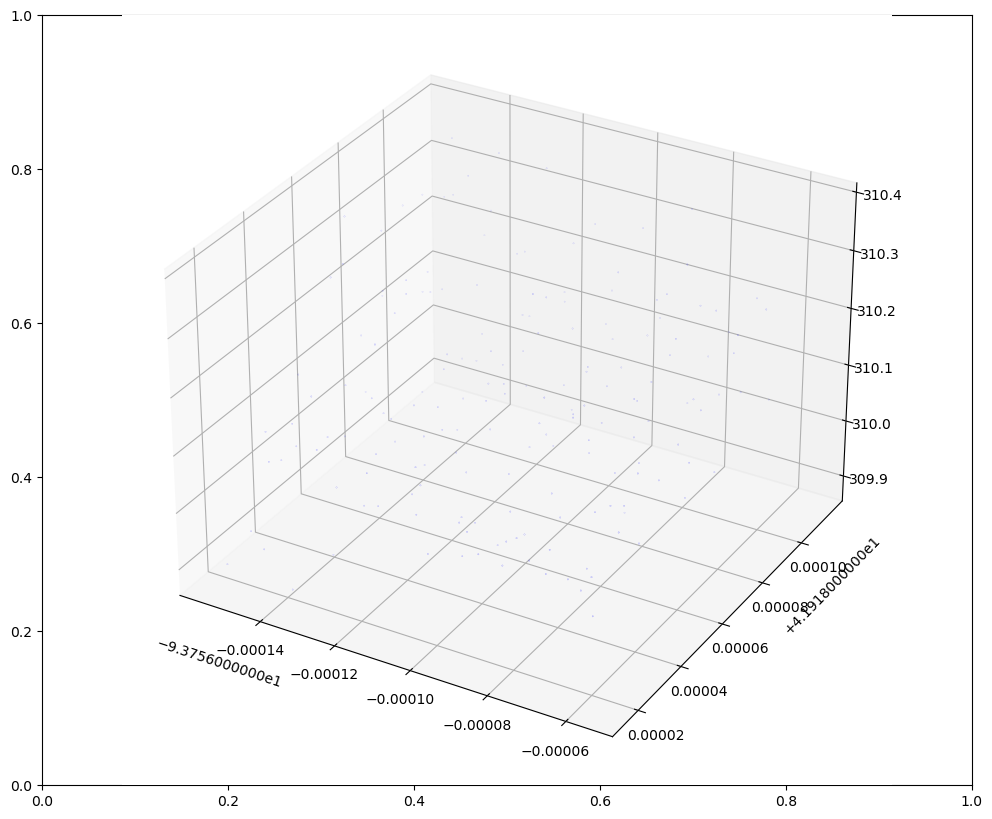

In [6]:
import numpy as np
import matplotlib.pyplot as plt
x = geo_df.geometry.x
y = geo_df.geometry.y
z = geo_df.elevation
    
points = np.vstack((x, y, z)).transpose()
    
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax = plt.axes(projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2],  s=0.01, color="blue")
plt.show()